# Lab 3.6 - Student Notebook

## Overview

This lab is a continuation of the guided labs in Module 3.

In this lab, you will evaluate the model that you trained in previous modules. You will also calculate metrics based on the results of the test data.


## Introduction to the business scenario

You work for a healthcare provider, and want to improve the detection of abnormalities in orthopedic patients. 

You are tasked with solving this problem by using machine learning (ML). You have access to a dataset that contains six biomechanical features and a target of *normal* or *abnormal*. You can use this dataset to train an ML model to predict if a patient will have an abnormality.


## About this dataset

This biomedical dataset was built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, France. The data has been organized in two different, but related, classification tasks. 

The first task consists in classifying patients as belonging to one of three categories: 

- *Normal* (100 patients)
- *Disk Hernia* (60 patients)
- *Spondylolisthesis* (150 patients)

For the second task, the categories *Disk Hernia* and *Spondylolisthesis* were merged into a single category that is labeled as *abnormal*. Thus, the second task consists in classifying patients as belonging to one of two categories: *Normal* (100 patients) or *Abnormal* (210 patients).


## Attribute information

Each patient is represented in the dataset by six biomechanical attributes that are derived from the shape and orientation of the pelvis and lumbar spine (in this order): 

- Pelvic incidence
- Pelvic tilt
- Lumbar lordosis angle
- Sacral slope
- Pelvic radius
- Grade of spondylolisthesis

The following convention is used for the class labels: 
- DH (Disk Hernia)
- Spondylolisthesis (SL)
- Normal (NO) 
- Abnormal (AB)

For more information about this dataset, see the [Vertebral Column dataset webpage](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Dataset attributions

This dataset was obtained from:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


# Lab setup

Because this solution is split across several labs in the module, you run the following cells so that you can load the data and train the model to be deployed.

**Note:** The setup can take up to 5 minutes to complete.

## Importing the data and training the model

By running the following cells, the data will be imported and ready for use. 

**Note:** The following cells represent the key steps in the previous labs.


In [1]:
bucket='c123510a2993953l7602949t1w804076807477-labbucket-hxbdh1fodmnd'

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-16-18-14-51-381



2024-09-16 18:14:53 Starting - Starting the training job..
2024-09-16 18:15:07 Starting - Preparing the instances for training.....
2024-09-16 18:15:38 Downloading - Downloading input data......
2024-09-16 18:16:14 Downloading - Downloading the training image.......
2024-09-16 18:16:55 Training - Training image download completed. Training in progress....
2024-09-16 18:17:15 Uploading - Uploading generated training model..
2024-09-16 18:17:28 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-09-16-18-17-33-528


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-09-16-18-17-34-149


.............................................
.[2024-09-16:18:25:07:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-16:18:25:07:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-16:18:25:07:INFO] nginx config: 
worker_processes auto;
daemon off;
[2024-09-16:18:25:07:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-16:18:25:07:INFO] No GPUs detected (normal if no gpus installed)
[2024-09-16:18:25:07:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;


# Step 1: Exploring the results

The output from the model will be a probablility. You must first convert that probability into one of the two classes, either *0* or *1*. To do this, you can create a function to perform the conversion. Note the use of the threshold in the function.

In [4]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


Based on these results, you can see that the initial model might not be that good. It's difficult to tell by comparing a few values.

Next, you will generate some metrics to see how well the model performs.


# Step 2: Creating a confusion matrix

A *confusion matrix* is one of the key ways of measuring a classification model's performance. It's a table that maps out the correct and incorrect predictions. After you calculate a confusion matrix for your model, you can generate several other statistics. However, you will start by only creating the confusion matrix.

To create a confusion matrix, you need both the target values from your test data *and* the predicted value. 

Get the targets from the test DataFrame.

In [5]:
test_labels = test.iloc[:,0]
test_labels.head()

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

Now, you can use the *scikit-learn* library, which contains a function to create a confusion matrix.

In [6]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,2,19


You results will vary, but you should have results that are similiar to this example:

_ | Normal | Abnormal
---------- | ----: | ----:
Normal | 7  | 3
Abnormal | 3  | 18



The previous table shows that the model correctly predicted *7 Normal* and *18 Abnormal* values. However, it incorrectly predicted *3 Normal* and *3 Abnormal* values. 

By using the *seaborn* and *matplotlib* Python libraries, you can plot these values in a chart to make them easier to read.

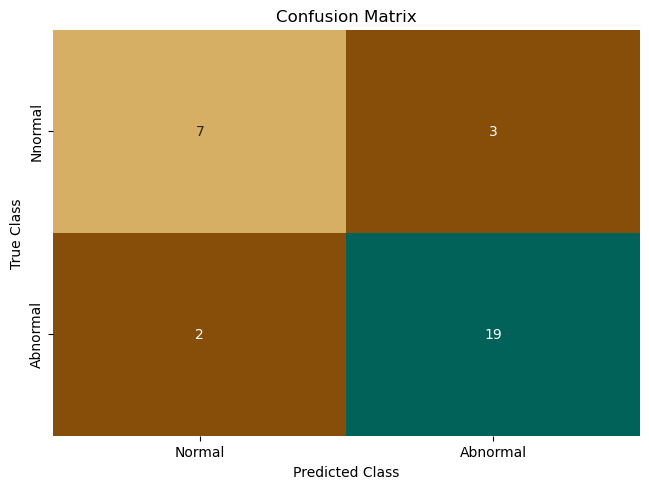

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

**Tip:** If the chart doesn't display the first time, try running the cell again.

If these results are good enough for your application, then the model might be good enough. However, because there are consequences from incorrectly predicting *Normal* values -- that is, no abnormality was found when there actually was one -- the focus should be on reducing this result.

# Step 3: Calculating performance statistics

If you want to compare this model to the next model that you create, you need some metrics that you can record. For a binary classification problem, the confusion matrix data can be used to calculate various metrics.

To start, extract the values from the confusion matrix cells into variables.

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

You can now calculate some statistics.


### Sensitivity

*Sensitivity* is also known as *hit rate*, *recall*, or *true positive rate (TPR)*. It measures the proportion of the actual positives that are correctly identified.

In this example, the sensitivity is *the probablity of detecting an abnormality for patients with an abnormality*.

In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

**Question:** Is the sensitivity good enough for this scenario?


### Specificity

The next statistic is *specificity*, which is also known as the *true negative*. It measures the proportion of the actual negatives that are correctly identified.

In this example, the specificity is *the probablity of detecting normal, for patients who are normal*.

In [ ]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


**Question:** Is this specificity too low, exactly right, or too high? What value  would you want to see here, given the scenario?



### Positive and negative predictive values

The *precision*, or *positive predictive value*, is the proportion of positive results.

In this example, the positive predictive value is *the probability that subjects with a positive screening test truly have an abnormality*.

In [ ]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

The *negative predictive value* is the proportion of negative results.

In this example, the negative predictive value is *the probability that subjects with a negative screening test truly have an abnormality*.

In [ ]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Think about the impact of these values. If you were a patient, how worried should you be if the test for an abnormality was positive? On the opposite side, how reassured should you be if you tested negative?


### False positive rate

The *false positive rate (FPR)* is the probability that a false alarm will be raised, or that *a positive result will be given when the true value is negative*. 

In [ ]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

### False negative rate

The *false negative rate* -- or *miss rate* -- is *the probability that a true positive will be missed by the test*.

In [ ]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

### False discovery rate

In this example, the *false discovery rate* is *the probability of predicting an abnormality when the patient doesn't have one*.

In [ ]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

### Overall accuracy

How accuracte is your model?

In [ ]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

In summary, you calculated the following metrics from your model:

In [ ]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

**Challenge task:** Record the previous values, then go back to step 1 and change the value used for the threshold. Values you should try are *.25* and *.75*. 

Did those threshold values make a difference?

# Step 4: Calculating the AUC-ROC Curve

The scikit-learn library has functions that can help you compute the *area under the receiver operating characteristic curve (AUC-ROC)*.

- The ROC is a probability curve.
- The AUC tells you how well the model can distinguish between classes. 

The AUC can be calculated. As you will see in the next lab, it can be used to measure the performance of the model. 

In this example, the higher the AUC, the better the model is at distinguishing between abnormal and normal patients.

Depending on the value you set for the threshold, the AUC can change. You can plot the AUC by using the probability instead of your converted class.


In [ ]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Typically, the ROC curve is plotted with the TPR against the FPR, where the TPR is on the y-axis and the FPR is on the x-axis.

scikit-learn has the **roc_curve** function to help generate those values to plot.

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)

finite_indices = np.isfinite(thresholds) 
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(fpr_finite, tpr_finite, label='ROC curve (area = %0.2f)' % auc(fpr_finite, tpr_finite))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(fpr_finite, thresholds_finite, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()

**Challenge task:** Update the previous code to use *target_predicted_binary* instead of *target_predicted*. How does that change the graph? Which is the most useful?

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.